In [2]:
import numpy as np

import matplotlib
from matplotlib import pyplot as plt

from IPython.display import HTML
from IPython.display import display

from skeleton_models import ntu_rgbd, get_kernel_by_group, ntu_ss_1, ntu_ss_2, ntu_ss_3, partial
from torch.utils.data import Dataset, DataLoader
#from layers import clones, GenerateNodes, EncoderUnit, DecoderUnit, SpatialGCN
#from model import ActionEmbeddingTransformer, TwoLayersGCNPoseEncoder, EncoderStack, DecoderStack, StepByStepUpsampling, BetterThatBestModel 
import os, glob

from render import animate
import math, copy, time
import torch
import torch.nn as nn
import torch.nn.functional as F

Shape = (83, 25, 3)


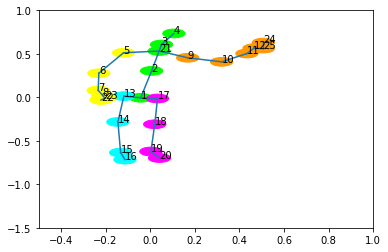

In [3]:
sample_data1 = np.load('../datasets/NTURGB-D/Python/raw_npy/S003C001P008R002A023.skeleton.npy', allow_pickle=True)[()]
sample_data2 = np.load('../datasets/NTURGB-D/Python/raw_npy/S003C001P016R001A023.skeleton.npy', allow_pickle=True)[()]
sequence1 =  sample_data1['skel_body0']
print('Shape = {}'.format(sequence1.shape))
animate(sequence1 - sequence1[0,0], ntu_rgbd)

In [4]:


adjacency = get_kernel_by_group(ntu_rgbd)

/mnt/hielo/projects/pesquisa/mestrado/action-embedding-transformer/skeleton_models.py:62: RuntimeWarning: divide by zero encountered in true_divide
  norm_coeficient = 1/norm_coeficient


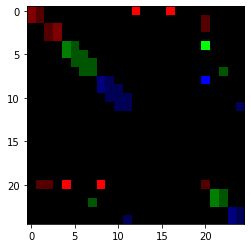

In [5]:
plt.imshow(adjacency.transpose(1,2,0)[:,:,0:3])

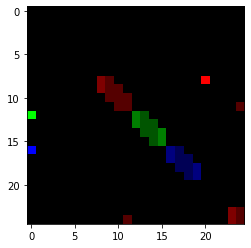

In [6]:
plt.imshow(adjacency.transpose(1,2,0)[:,:,2:5])

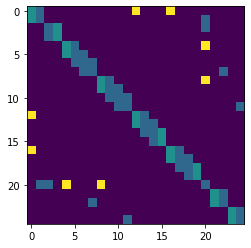

In [7]:
plt.imshow(adjacency.sum(axis=0))

In [9]:

def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        x = x.permute(0, 2, 3, 1).contiguous() # [N, Cout * H, T, V] -> [N, T, V, Cout * H] ;
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        x = self.a_2 * (x - mean) / (std + self.eps) + self.b_2
        x = x.permute(0, 3, 1, 2).contiguous() # [N, T, V, Cout * H] -> [N, Cout * H, T, V]
        return x


class SpatialGCN(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.conv = nn.Conv2d(in_channels,
                      out_channels * kernel_size,
                      kernel_size=(1, 1))

    def forward(self, x, A):
        out = self.conv(x) # [N,Cin,T,V] -> [N, K * Cout, T, V]
        out = F.relu(out)
        n, kc, t, v = out.size()
        k = self.kernel_size
        c_in = self.in_channels
        c_out = self.out_channels
        out = out.view(n, k, c_out, t, v) # [N, K * Cout, T, V] -> [N, K, Cout, T, V]
        x = torch.einsum('nkctv,kvw->nctw', (out, A)) # [N, K, Cout, T, V] -> [N, Cout, T, V]
        return x



class TemporalSelfAttention(nn.Module):
    def __init__(self, heads, num_nodes, node_channel_in, node_channel_out):
        super().__init__()
        self.h = heads
        self.v = num_nodes
        self.node_in = node_channel_in
        self.node_out = node_channel_out
        self.w_keys = clones(nn.Linear(num_nodes*node_channel_in, num_nodes*node_channel_out), heads)
        self.w_queries = clones(nn.Linear(num_nodes*node_channel_in, num_nodes*node_channel_out), heads)
        self.w_values = clones(nn.Linear(num_nodes*node_channel_in, num_nodes*node_channel_out), heads)

    def forward(self, x, mask=None):
        n, c, t, v = x.size() # [N, Cin, T, V]
        x = x.permute(0, 2, 1, 3).contiguous() # [N, Cin, T, V] -> [N, T, Cin, V]
        x = x.view(n, t, c*v)                  # [N, Cin, T, V] -> [N, T, Cin*V]

        keys = torch.stack([ l(x) for l in self.w_keys], dim=1)
        queries = torch.stack([ l(x) for l in self.w_queries], dim=1)
        values = torch.stack([ l(x) for l in self.w_values], dim=1)

        att = torch.matmul(queries, keys.permute(0,1,3,2)) / np.sqrt(self.node_out*self.v)
        if mask is not None:
            att = att.masked_fill(mask == 0, -1e9)
        att = torch.softmax(att, dim=-1)

        x = torch.matmul(att, values) #  -> [N, H, T, Cout*V]
        x = x.permute(0, 2, 3, 1).contiguous() # [N, H, T, Cout*V] -> [N, T, Cout*V, H]
        x = x.view(n, t, v, self.node_out *  self.h) # [N, T, V * Cout, H] -> [N, T, V, Cout * H]
        x = x.permute(0, 3, 1, 2).contiguous() # [N, T, V, Cout * H] -> [N, Cout * H, T, V]
        return x

class TemporalInputAttention(nn.Module):
    def __init__(self, heads, num_nodes, node_channel_in, node_channel_out, node_memory_in):
        super().__init__()
        self.h = heads
        self.v = num_nodes
        self.node_in = node_channel_in
        self.memory_in = node_memory_in
        self.node_out = node_channel_out
        self.w_keys = clones(nn.Linear(num_nodes*node_channel_in, num_nodes*node_channel_out), heads)
        self.w_queries = clones(nn.Linear(num_nodes*node_memory_in, num_nodes*node_channel_out), heads)
        self.w_values = clones(nn.Linear(num_nodes*node_memory_in, num_nodes*node_channel_out), heads)

    def forward(self, x, m):
        n, c, t, v = x.size() # [N, Cin, T, V]
        x = x.permute(0, 2, 1, 3).contiguous() # [N, Cin, T, V] -> [N, T, Cin, V]
        x = x.view(n, t, c*v)                  # [N, Cin, T, V] -> [N, T, Cin*V]

        mn, mc, mt, mv = m.size() # [N, Cin, T, V]
        m = m.permute(0, 2, 1, 3).contiguous() # [N, Cin, T, V] -> [N, T, Cin, V]
        m = m.view(mn, mt, mc*mv)                  # [N, Cin, T, V] -> [N, T, Cin*V]

        keys = torch.stack([ l(x) for l in self.w_keys], dim=1)
        queries = torch.stack([ l(m) for l in self.w_queries], dim=1)
        values = torch.stack([ l(m) for l in self.w_values], dim=1)

        att = torch.matmul(queries, keys.permute(0,1,3,2)) / np.sqrt(self.node_out*self.v)
        att = torch.softmax(att, dim=1)

        x = torch.matmul(att, values) #  -> [N, H, T, Cout*V]
        x = x.permute(0, 2, 3, 1).contiguous() # [N, H, T, Cout*V] -> [N, T, Cout*V, H]
        x = x.view(n, t, v, self.node_out *  self.h) # [N, T, V * Cout, H] -> [N, T, V, Cout * H]
        x = x.permute(0, 3, 1, 2).contiguous() # [N, T, V, Cout * H] -> [N, Cout * H, T, V]
        return x

class EncoderUnit(nn.Module):
    def __init__(self, heads, node_channel_in, node_channel_mid, node_channel_out, num_nodes=25, kernel_size=5):
        super().__init__()

        self.temporal_self_attention = TemporalSelfAttention(
            heads=heads,
            num_nodes=num_nodes,
            node_channel_in=node_channel_in,
            node_channel_out=node_channel_mid)

        self.spatial_gcn = SpatialGCN(
            in_channels=heads*node_channel_mid,
            out_channels=node_channel_out,
            kernel_size=kernel_size)

        self.norm_1 = LayerNorm(node_channel_mid*heads)
        self.norm_2 = LayerNorm(node_channel_out)

    def forward(self, x, A):
        x = self.temporal_self_attention(x)
        x = self.norm_1(x)
        x = self.spatial_gcn(x, A)
        x = self.norm_2(x)
        return x

class DecoderUnit(nn.Module):
    def __init__(self, heads, node_channel_in, memory_channel_in, node_channel_mid, node_channel_out, num_nodes=25, kernel_size=5):
        super().__init__()

        self.temporal_self_attention = TemporalSelfAttention(
            heads=heads,
            num_nodes=num_nodes,
            node_channel_in=node_channel_in,
            node_channel_out=node_channel_mid[0])

        self.temporal_input_attention =  TemporalInputAttention(
            heads=heads,
            num_nodes = num_nodes,
            node_channel_in=heads*node_channel_mid[0],
            node_channel_out=node_channel_mid[1],
            node_memory_in=memory_channel_in)

        self.spatial_gcn = SpatialGCN(
            in_channels=heads*node_channel_mid[1],
            out_channels=node_channel_out,
            kernel_size=kernel_size)

        self.norm_1 = LayerNorm(node_channel_mid[0]*heads)
        self.norm_2 = LayerNorm(node_channel_mid[1]*heads)
        self.norm_3 = LayerNorm(node_channel_out)

    def forward(self, x, m, A, mask):
        x = self.temporal_self_attention(x, mask)
        x = self.norm_1(x)
        x = self.temporal_input_attention(x, m)
        x = self.norm_2(x)
        x = self.spatial_gcn(x, A)
        x = self.norm_3(x)
        return x



class GenerateNodes(nn.Module):
    def __init__(self, total_nodes, node_channel_in, num_seeds, new_nodes, node_channel_out=3):
        super().__init__()
        # self.linear = nn.Linear(total_nodes*node_channel_in + num_seeds*node_channel_out, node_channel_out)
        linear_input_size = total_nodes*node_channel_in + num_seeds*node_channel_out
        self.node_projections = clones(nn.Linear(linear_input_size, node_channel_out), new_nodes)

    def forward(self, x, seeds=None):
        n, c, t, v = x.size()
        x = x.permute(0, 2, 1, 3).contiguous() # [N, C, T, V] -> [N, T, C, V]
        x = x.view(n, t, c*v)

        if seeds != None:
            sn, st, sc, sv = seeds.size()
            seeds = seeds.view(n, t, sc*sv)
            mix = torch.cat( (x,seeds), dim=2 )
        else:
            mix = x

        new_nodes = torch.stack([ l(mix) for l in self.node_projections], dim=3)

        return new_nodes




In [56]:
conf_kernel_size = 5
conf_num_nodes = 25
conf_heads = 5
conf_encoding_per_node = 20
conf_internal_per_node = int(conf_encoding_per_node/conf_heads)

class BestModelEver(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.spatial_gcn_1 = SpatialGCN(3, 12, conf_kernel_size)
        self.spatial_gcn_2 = SpatialGCN(12, conf_encoding_per_node, conf_kernel_size)

        self.encoder_1, self.encoder_2, self.encoder_3 = clones(EncoderUnit(
            heads=conf_heads,
            node_channel_in=conf_encoding_per_node,
            node_channel_mid=conf_internal_per_node,
            node_channel_out=conf_encoding_per_node,
            num_nodes=conf_num_nodes,
            kernel_size=conf_kernel_size
        ), 3)
        
        self.decoder_1, self.decoder_2, self.decoder_3 = clones(DecoderUnit(
            heads=3,
            node_channel_in=conf_encoding_per_node,
            memory_channel_in=conf_encoding_per_node,
            node_channel_mid=(conf_internal_per_node,conf_internal_per_node),
            node_channel_out=conf_encoding_per_node,
            num_nodes=conf_num_nodes,
            kernel_size=conf_kernel_size
        ),3 )
        
        
        self.generate_nodes_1 = GenerateNodes(
            total_nodes = conf_num_nodes, 
            node_channel_in = conf_encoding_per_node, 
            num_seeds = 0, 
            new_nodes = ntu_ss_1['num_nodes']
        )
        
        new_count = ntu_ss_2['num_nodes'] - ntu_ss_1['num_nodes']
        self.generate_nodes_2 = GenerateNodes(
            total_nodes = conf_num_nodes, 
            node_channel_in = conf_encoding_per_node, 
            num_seeds = ntu_ss_1['num_nodes'], 
            new_nodes = new_count
        )
        
        new_count = ntu_ss_3['num_nodes'] - ntu_ss_2['num_nodes']
        self.generate_nodes_3 = GenerateNodes(
            total_nodes = conf_num_nodes, 
            node_channel_in = conf_encoding_per_node, 
            num_seeds = ntu_ss_2['num_nodes'], 
            new_nodes = new_count
        )
        


    def forward(self, x_in, x_out, A):
        # Expectativa de entrada [N,Cin,T,V]
        
        n_out, c_out, t_out, v_out = x_out.size()
        mask = subsequent_mask(t_out)
        
        e_in = self.spatial_gcn_1(x_in, A)
        e_in = self.spatial_gcn_2(e_in, A)
        
        
        e_out = self.spatial_gcn_1(x_out, A)
        e_out = self.spatial_gcn_2(e_out, A)
            
        m = self.encoder_1(e_in, A)
        m = self.encoder_2(m, A)
        m = self.encoder_3(m, A)
       
        
        d1 = self.decoder_1(e_out, m, A, mask)
        d2 = self.decoder_2(d1, m, A, mask)
        d3 = self.decoder_3(d2, m, A, mask) # [N, Cout, T, V]
        
        
        partial1 = self.generate_nodes_1(d1)
       
        
        temp = self.generate_nodes_2(d2, partial1)
        partial2 = torch.cat( (partial1,temp), dim=3 )
        
        temp = self.generate_nodes_3(d3, partial2)
        partial3 = torch.cat( (partial2,temp), dim=3 )
        
        
        partial1 = partial1.permute(0, 2, 1, 3).contiguous() # [N, T, C, V] -> [N, C, T, V]
        partial2 = partial2.permute(0, 2, 1, 3).contiguous() # [N, T, C, V] -> [N, C, T, V]
        partial3 = partial3.permute(0, 2, 1, 3).contiguous() # [N, T, C, V] -> [N, C, T, V]
        
        return partial1, partial2, partial3


In [57]:
print(sequence2.shape)

X = torch.from_numpy(sequence2).float().permute(2, 0, 1).unsqueeze(0)
A = torch.from_numpy(adjacency).float()
print(X.size())
print(A.size())

(59, 25, 3)
torch.Size([1, 3, 59, 25])
torch.Size([5, 25, 25])


In [58]:
class NTUDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform #root_dir
        self.files = glob.glob(root_dir+'*.npy')
        self.crop = CropSequence(20)
        
    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_data = np.load(self.files[idx], allow_pickle=True)[()]
        pose_data =  file_data['skel_body0']
        pose_data = self.crop(pose_data)
        if self.transform:
            pose_data = self.transform(pose_data)
        
        pose_data = pose_data.transpose(2, 0, 1)
        return pose_data
    
class CropSequence(object):
    def __init__(self, lenght):
        self.lenght = lenght

    def __call__(self, sample):
        return sample[0:self.lenght]
    
ntu_dataset = NTUDataset(root_dir='../datasets/NTURGB-D/Python/raw_npy/')
ntu_dataset[1].shape


# model(X,X,A)
    

(3, 20, 25)

In [59]:
from torch.utils.data import DataLoader 
from tqdm import tqdm

model = BestModelEver()

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform(p)

criterion = torch.nn.MSELoss()

loader = DataLoader(ntu_dataset, batch_size=100, shuffle=True)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.00005)
optimizer = torch.optim.Adam(model.parameters(), lr=0.000005)

#print()

for epoch in range(20):
    for data in tqdm(loader):
        data = data.float()
        labels3 =  data[..., ntu_ss_3['ss_selection']]
        partial1, partial2, partial3 = model(data, data, A)

        loss = criterion(partial3, labels3)
        loss.backward()

        # update parameters
        optimizer.step()

    print('loss {}'.format(loss.item()))
    
    
    

<ipython-input-59-f5087f33534d>:8: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(p)
  0%|          | 0/566 [00:00<?, ?it/s]

loss 0.22445665299892426


  0%|          | 0/566 [00:00<?, ?it/s]

loss 0.19384965300559998


  0%|          | 0/566 [00:00<?, ?it/s]

loss 0.22495634853839874


  0%|          | 0/566 [00:00<?, ?it/s]

loss 0.16139188408851624


  0%|          | 0/566 [00:00<?, ?it/s]

loss 0.19546742737293243


  0%|          | 0/566 [00:00<?, ?it/s]

loss 0.28391575813293457


  0%|          | 0/566 [00:00<?, ?it/s]

loss 0.2075512707233429


  0%|          | 0/566 [00:00<?, ?it/s]

loss 0.28326380252838135


  0%|          | 0/566 [00:00<?, ?it/s]

loss 0.2504737079143524


  0%|          | 0/566 [00:00<?, ?it/s]

loss 0.20104734599590302


  0%|          | 0/566 [00:00<?, ?it/s]

loss 0.2299751192331314


  0%|          | 0/566 [00:00<?, ?it/s]

loss 0.19369100034236908


  0%|          | 0/566 [00:00<?, ?it/s]

loss 0.21247458457946777


  0%|          | 0/566 [00:00<?, ?it/s]

loss 0.18607944250106812


  0%|          | 0/566 [00:00<?, ?it/s]

loss 0.10963903367519379


  0%|          | 0/566 [00:00<?, ?it/s]

loss 0.16091902554035187


  0%|          | 0/566 [00:00<?, ?it/s]

loss 0.20076261460781097


  0%|          | 0/566 [00:00<?, ?it/s]

loss 0.21238283812999725


  0%|          | 0/566 [00:00<?, ?it/s]

loss 0.26032885909080505


100%|██████████| 566/566 [43:01<00:00,  4.56s/it]

loss 0.25731226801872253


In [ ]:
for epoch in range(10):
    for data in tqdm(loader):
        data = data.float()
        labels3 =  data[..., ntu_ss_3['ss_selection']]
        partial1, partial2, partial3 = model(data, data, A)

        loss = criterion(partial3, labels3)
        loss.backward()

        # update parameters
        optimizer.step()

    print('loss {}'.format(loss.item()))
    

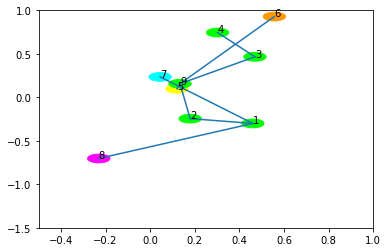

In [68]:
partial3[0].permute(1,2,0).size()
animate(partial3[0].permute(1,2,0), ntu_ss_3)

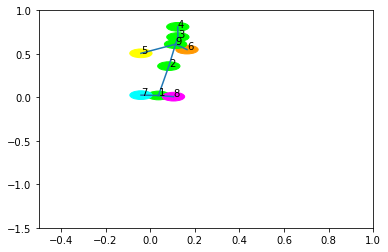

In [76]:
labels3[0].permute(1,2,0).size()
animate(labels3[0].permute(1,2,0), ntu_ss_3)